In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import loguniform, randint

%matplotlib inline

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data
    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append(
            (f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i]))
        )
    return pd.Series(data=out_col, index=mean_scores.index)

In [3]:
with open("data/processed/training_arm.pickle", "rb") as f:
    training_arm = pickle.load(f)

with open("data/processed/output_models.pickle", "rb") as f:
    output_models = pickle.load(f)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    output_models, training_arm,
    test_size=0.3, random_state=2022
)

print(X_train.shape)
print(y_train.shape)

(28000, 6001)
(28000, 3000)


In [5]:
final_model = Ridge(alpha=10.0)
final_model.fit(X_train, y_train)

Ridge(alpha=10.0)

In [6]:
# # There are ~5,000 observations for each reaching angle
# # After train-test splitting, this would be around 3500
# # in the train set. Using this prior knowledge, we can
# # set the min_samples_split to be in the same order as 
# # 3500.
# final_model = RandomForestRegressor(
#     n_jobs=-1,
#     n_estimators=50,
#     min_samples_split=1_000
# )
# final_model.fit(X_train, y_train)

In [7]:
# Train score
train_prediction = final_model.predict(X_train)
train_rmse = np.sqrt(np.mean((y_train - train_prediction)**2))
print(train_rmse)

25.16041556439691


In [8]:
# Test score
prediction = final_model.predict(X_test)
rmse = np.sqrt(np.mean((y_test - prediction)**2))
print(rmse)

27.81000715663491


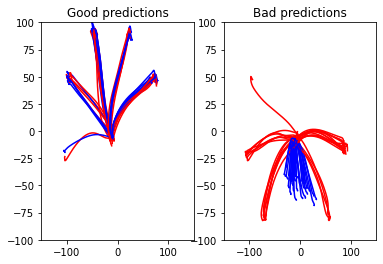

In [9]:
good_examples = 0
bad_examples = 0

ax_good = plt.subplot(121)
ax_bad = plt.subplot(122)

for idx in range(X_test.shape[0]):
    if good_examples < 30 and bad_examples < 30:
        sample_X = np.reshape(X_test[idx, :], (1, X_train.shape[1]))
        sample_y = y_test[idx, :]
        pred = final_model.predict(sample_X)
        rmse = np.sqrt(np.mean((pred - sample_y)**2))
        if rmse < 5:
            good_examples += 1
            ax_good.plot(sample_y[:1000], sample_y[1000:2000], color="r")
            ax_good.plot(pred[0, :1000], pred[0, 1000:2000], color="b")
        if rmse > 30:
            bad_examples += 1
            ax_bad.plot(sample_y[:1000], sample_y[1000:2000], color="r")
            ax_bad.plot(pred[0, :1000], pred[0, 1000:2000], color="b")

ax_good.title.set_text("Good predictions")
ax_bad.title.set_text("Bad predictions")
ax_good.set_xlim([-150, 150])
ax_good.set_ylim([-100, 100])
ax_bad.set_xlim([-150, 150])
ax_bad.set_ylim([-100, 100])
plt.show()